In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
hppc_DIR = "../data/hppc/"
crate_DIR = "../data/crate/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_cycling/"
res_DIR = "../data/results/"

%matplotlib widget

In [2]:
spm = pybamm.lithium_ion.SPMe(
    {
        # "SEI": "ec reaction limited",
        # # "loss of active material": ("stress-driven","none"),
        # "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [3]:
parameter_values = get_parameter_values()

In [4]:
parameter_values.search("entropic")

Negative electrode OCP entropic change [V.K-1]	<function graphite_entropic_change_PeymanMPM at 0x00000263B2702D30>
Positive electrode OCP entropic change [V.K-1]	<function NMC_entropic_change_PeymanMPM at 0x00000263B2702DC0>


In [5]:
cell = 2
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
print(cell_no)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
cyc_data_raw = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
if int(cell_no)%3 == 1:
  cyc_data_raw = cyc_data_raw[ cyc_data_raw['Cycle number'] == 1 ]
else:
  cyc_data_raw = cyc_data_raw[ cyc_data_raw['Cycle number'] == 1 ]
cyc_data = cyc_data_raw.reset_index(drop=True)
t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
t_c1 = t_c1.values
I_c1 = cyc_data['Current [mA]']/1000
I_c1 = I_c1.values
V_c1 = cyc_data['Voltage [V]']
V_c1 = V_c1.values
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": 1.2676e-07,#2.7081e-07, #4.1759e-07,#2.7081e-07, #2.5112e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.2713e-06,#3.7576e-06, #3.2693e-06,#3.7576e-06, #2.4741e-06,
        "Positive electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity,
        # "Positive electrode diffusivity [m2.s-1]" NMC_diffusivity,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
        "Upper voltage cut-off [V]": 4.22,
    },
    check_already_exists=False,
)
t_sim = np.arange(0,t_c1[-1],1)
timescale = parameter_values.evaluate(spm.timescale)
current_interpolant = pybamm.Interpolant(
  #  drive_cycle[:, 0], drive_cycle[:, 1], timescale * pybamm.t
  t_c1, -I_c1, timescale * pybamm.t
)
pybamm.set_logging_level("NOTICE")
parameter_values["Current function [A]"] = current_interpolant
# var_pts=var_pts,
sim0 = pybamm.Simulation(spm, 
                        parameter_values=parameter_values, 
                        solver=pybamm.CasadiSolver(
                            mode="safe", 
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                            )
                        )
SOC_0 = 0.003
if cell>12:
  SOC_0 = 0.5
if cell==15:
  SOC_0 = 0.48
if cell==21:
  SOC_0 = 0.51
if cell in [13,16,19]:
  SOC_0 = 0.48
if cell==10:
  SOC_0 = 0.04
if cell in [14,17]:
  SOC_0 = 0.45
if cell==20:
  SOC_0 = 0.39
sim0.solve(t_eval=t_sim,initial_soc =SOC_0)
sol0 = sim0.solution
t0 =  sol0["Time [s]"].entries
V0 =  sol0["Terminal voltage [V]"].entries
I0 =  sol0["Current [A]"].entries
Q0 = -sol0['Discharge capacity [A.h]'].entries
cs_sur_n0 =   sol0["X-averaged negative particle surface concentration"].entries
cs_sur_p0 =   sol0["X-averaged positive particle surface concentration"].entries
cs_ave_n0 =   sol0["Negative electrode volume-averaged concentration"].entries
cs_ave_p0 =   sol0["Positive electrode volume-averaged concentration"].entries

02


In [6]:
def graphite_diffusivity(sto, T):
  from pybamm import exp, constants
  D_ref = 5.0* 10 ** (-15)
  E_D_s = 0
  arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
  return D_ref * arrhenius

def NMC_diffusivity(sto, T):
  from pybamm import exp, constants
  D_ref = 8 * 10 ** (-15)
  E_D_s = 0
  arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
  return D_ref * arrhenius

def electrolyte_diffusivity(c_e, T):
  from pybamm import exp, constants
  D_c_e = 5.35 * 10 ** (-10)
  E_D_e = 0
  arrhenius = exp(E_D_e /constants.R * (1 / 298.15 - 1 / T))
  return D_c_e * arrhenius

def graphite_electrolyte_exchange_current_density(c_e, c_s_surf, c_s_max, T):
  from pybamm import exp, constants
  m_ref = 1.061 * 10 ** (-6)  # unit has been converted
  # units are (A/m2)(mol/m3)**1.5 - includes ref concentrations
  E_r = 0#37480
  arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

  return (
      m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
  )

def NMC_electrolyte_exchange_current_density(c_e, c_s_surf, c_s_max, T):
  from pybamm import exp, constants
  m_ref = 4.824 * 10 ** (-6)  # (A/m2)(mol/m3)**1.5 - includes ref concentrations
  E_r = 0 #39570
  arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

  return (
      m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
  )

def NMC_entropic_change(sto, c_s_max):
  return 0
  
def graphite_entropic_change(sto, c_s_max):
  return 0

In [7]:
def graphite_diffusivity(sto, T):
  from pybamm import exp, constants
  D_ref = 5.0* 10 ** (-15)
  E_D_s = 0
  arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
  return D_ref * arrhenius

def graphite_diffusivity1(sto, T):
  from pybamm import exp, constants
  D_ref = 5.0* 10 ** (-14)
  E_D_s = 0
  arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
  return D_ref * arrhenius

In [8]:
parameter_values.update(
    {
      # "Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity,
      "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity,
      # "Positive electrode diffusivity [m2.s-1]": NMC_diffusivity,
      # "Negative electrode exchange-current density [A.m-2]": graphite_electrolyte_exchange_current_density,
      # "Positive electrode exchange-current density [A.m-2]": NMC_electrolyte_exchange_current_density,
      # "Negative electrode OCP entropic change [V.K-1]": graphite_entropic_change,
      # "Positive electrode OCP entropic change [V.K-1]": NMC_entropic_change,
    },
    check_already_exists=False,
)

sim1 = pybamm.Simulation(spm, 
                        parameter_values=parameter_values, 
                        solver=pybamm.CasadiSolver(
                            mode="safe", 
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                            )
                        )
sim1.solve(t_eval=t_sim,initial_soc =SOC_0)
sol1 = sim1.solution
t1 =  sol1["Time [s]"].entries
V1 =  sol1["Terminal voltage [V]"].entries
I1 =  sol1["Current [A]"].entries
Q1 = -sol1['Discharge capacity [A.h]'].entries
cs_sur_n1 =   sol1["X-averaged negative particle surface concentration"].entries
cs_sur_p1 =   sol1["X-averaged positive particle surface concentration"].entries
cs_ave_n1 =   sol1["Negative electrode volume-averaged concentration"].entries
cs_ave_p1 =   sol1["Positive electrode volume-averaged concentration"].entries

In [9]:
parameter_values.update(
    {
      # "Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity1,
      "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity1,
      # "Positive electrode diffusivity [m2.s-1]": NMC_diffusivity1,
      # "Negative electrode exchange-current density [A.m-2]": graphite_electrolyte_exchange_current_density1,
      # "Positive electrode exchange-current density [A.m-2]": NMC_electrolyte_exchange_current_density1,
      # "Negative electrode OCP entropic change [V.K-1]": graphite_entropic_change,
      # "Positive electrode OCP entropic change [V.K-1]": NMC_entropic_change,
    },
    check_already_exists=False,
)

sim2 = pybamm.Simulation(spm, 
                        parameter_values=parameter_values, 
                        solver=pybamm.CasadiSolver(
                            mode="safe", 
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                            )
                        )
sim2.solve(t_eval=t_sim,initial_soc =SOC_0)
sol2 = sim2.solution
t2 =  sol2["Time [s]"].entries
V2 =  sol2["Terminal voltage [V]"].entries
I2 =  sol2["Current [A]"].entries
Q2 = -sol2['Discharge capacity [A.h]'].entries
cs_sur_n2 =   sol2["X-averaged negative particle surface concentration"].entries
cs_sur_p2 =   sol2["X-averaged positive particle surface concentration"].entries
cs_ave_n2 =   sol2["Negative electrode volume-averaged concentration"].entries
cs_ave_p2 =   sol2["Positive electrode volume-averaged concentration"].entries

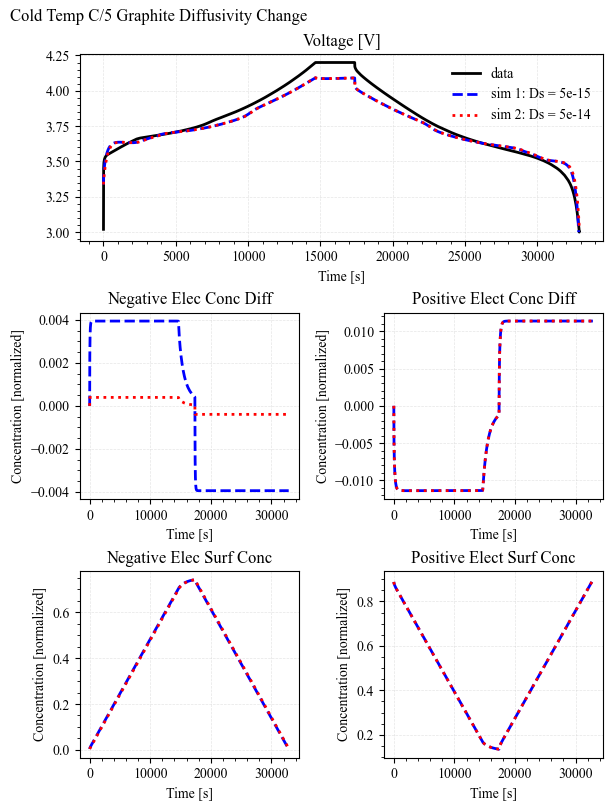

In [12]:
fig = plt.figure(figsize=(6, 8), constrained_layout = True)
gs = fig.add_gridspec(3,2)
ax1 = fig.add_subplot(gs[0,:])
ax1.plot(t_c1,V_c1,'k')
ax1.plot(t1,V1,'b--')
ax1.plot(t2,V2,'r:')
ax1.set_title("Voltage [V]")
ax1.set_xlabel("Time [s]")
ax1.legend([
            "data",
            "sim 1: Ds = 5e-15",
            "sim 2: Ds = 5e-14",
            ])
ax2 = fig.add_subplot(gs[1,0])
ax2.plot(t1,cs_sur_n1-cs_ave_n1,'b--')
ax2.plot(t2,cs_sur_n2-cs_ave_n2,'r:')
ax2.set_title("Negative Elec Conc Diff")
ax2.set_ylabel("Concentration [normalized]")
ax2.set_xlabel("Time [s]")
ax3 = fig.add_subplot(gs[1,1])
ax3.plot(t1,cs_sur_p1-cs_ave_p1,'b--')
ax3.plot(t2,cs_sur_p2-cs_ave_p2,'r:')
ax3.set_ylabel("Concentration [normalized]")
ax3.set_title("Positive Elect Conc Diff")
ax3.set_xlabel("Time [s]")
ax4 = fig.add_subplot(gs[2,0])
ax4.plot(t1,cs_sur_n1,'b--')
ax4.plot(t2,cs_sur_n2,'r:')
ax4.set_title("Negative Elec Surf Conc")
ax4.set_ylabel("Concentration [normalized]")
ax4.set_xlabel("Time [s]")
ax5 = fig.add_subplot(gs[2,1])
ax5.plot(t1,cs_sur_p1,'b--')
ax5.plot(t2,cs_sur_p2,'r:')
ax5.set_ylabel("Concentration [normalized]")
ax5.set_title("Positive Elect Surf Conc")
ax5.set_xlabel("Time [s]")
fig.suptitle("Cold Temp C/5 Graphite Diffusivity Change",horizontalalignment='right')
plt.savefig(fig_DIR + 'cell_'+cell_no+f'_graphite_diffusivity.png')

In [11]:
dfsdfsd

NameError: name 'dfsdfsd' is not defined

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax1 = axes.flat[0]
# ax1.plot(crate_data['Time [s]'],crate_data['Voltage [V]'])
ax1.plot(t_c1,V_c1,'k')
ax1.plot(t1,V1,'b--')
ax1.plot(t2,V2,'r:')
ax1.set_title("Voltage [V]")
ax1.set_xlabel("Time [s]")
ax1.legend(["data","sim 1","sim 2"])
ax2 = axes.flat[1]
# ax2.plot(crate_data['Time [s]'],crate_data['Current [mA]'])
ax2.plot(t_c1,-I_c1,'k')
ax2.plot(t1,I1,'b--')
ax2.plot(t2,I2,'r:')
ax2.set_title("Current [mA]'")
ax2.set_xlabel("Time [s]")
sim_des = "nmc"
# fig.suptitle("Cell = "+cell_no+ " "+ sim_des + " Exchange no Arrhenius")
fig.tight_layout()
plt.show()
# plt.savefig(fig_DIR + 'cell_'+cell_no+f'_{sim_des}_exchange_arrh.png')

In [ ]:
dfsdfsdrfsdf

In [ ]:
# for cell in range(1,22,3):
# for cell in range(3,22,3):
for cell in [2,3]:
  cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
  print(cell_no)
  eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
  cyc_data_raw = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
  if int(cell_no)%3 == 1:
    cyc_data_raw = cyc_data_raw[ cyc_data_raw['Cycle number'] == 1 ]
  else:
    cyc_data_raw = cyc_data_raw[ cyc_data_raw['Cycle number'] == 1 ]
  cyc_data = cyc_data_raw.reset_index(drop=True)
  t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
  t_c1 = t_c1.values
  I_c1 = cyc_data['Current [mA]']/1000
  I_c1 = I_c1.values
  V_c1 = cyc_data['Voltage [V]']
  V_c1 = V_c1.values
  parameter_values = get_parameter_values()
  parameter_values.update(
      {
          "Positive electrode LAM constant proportional term [s-1]": 1.2676e-07,#2.7081e-07, #4.1759e-07,#2.7081e-07, #2.5112e-07,
          "Negative electrode LAM constant proportional term [s-1]": 1.2713e-06,#3.7576e-06, #3.2693e-06,#3.7576e-06, #2.4741e-06,
          "Positive electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
          "Negative electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
          "Negative electrode active material volume fraction": eps_n_data,
          "Positive electrode active material volume fraction": eps_p_data,
          "Initial temperature [K]": 273.15+Temp,
          "Ambient temperature [K]": 273.15+Temp,
          "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
          "EC diffusivity [m2.s-1]": 8.30909086e-19,
          "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
          # "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity,
          # "Positive electrode diffusivity [m2.s-1]" NMC_diffusivity,
          # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
          # "EC diffusivity [m2.s-1]": 2e-18,
          # "SEI growth activation energy [J.mol-1]": 0,
          "Upper voltage cut-off [V]": 4.22,
      },
      check_already_exists=False,
  )
  t_sim = np.arange(0,t_c1[-1],1)
  timescale = parameter_values.evaluate(spm.timescale)
  current_interpolant = pybamm.Interpolant(
    #  drive_cycle[:, 0], drive_cycle[:, 1], timescale * pybamm.t
    t_c1, -I_c1, timescale * pybamm.t
  )
  pybamm.set_logging_level("NOTICE")
  parameter_values["Current function [A]"] = current_interpolant
  # var_pts=var_pts,
  sim0 = pybamm.Simulation(spm, 
                          parameter_values=parameter_values, 
                          solver=pybamm.CasadiSolver(
                              mode="safe", 
                              rtol=1e-6, 
                              atol=1e-6,
                              dt_max=10,
                              )
                          )
  SOC_0 = 0.003
  if cell>12:
    SOC_0 = 0.5
  if cell==15:
    SOC_0 = 0.48
  if cell==21:
    SOC_0 = 0.51
  if cell in [13,16,19]:
    SOC_0 = 0.48
  if cell==10:
    SOC_0 = 0.04
  if cell in [14,17]:
    SOC_0 = 0.45
  if cell==20:
    SOC_0 = 0.39
  sim0.solve(t_eval=t_sim,initial_soc =SOC_0)
  sol0 = sim0.solution
  t0 =  sol0["Time [s]"].entries
  V0 =  sol0["Terminal voltage [V]"].entries
  I0 =  sol0["Current [A]"].entries
  Q0 = -sol0['Discharge capacity [A.h]'].entries
  
  def graphite_diffusivity(sto, T):
    from pybamm import exp, constants
    D_ref = 5.0* 10 ** (-15)
    E_D_s = 0
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
    return D_ref * arrhenius

  def NMC_diffusivity(sto, T):
    from pybamm import exp, constants
    D_ref = 8 * 10 ** (-15)
    E_D_s = 0
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
    return D_ref * arrhenius

  def electrolyte_diffusivity(c_e, T):
    from pybamm import exp, constants
    D_c_e = 5.35 * 10 ** (-10)
    E_D_e = 0
    arrhenius = exp(E_D_e /constants.R * (1 / 298.15 - 1 / T))
    return D_c_e * arrhenius

  def graphite_electrolyte_exchange_current_density(c_e, c_s_surf, c_s_max, T):
    from pybamm import exp, constants
    m_ref = 1.061 * 10 ** (-6)  # unit has been converted
    # units are (A/m2)(mol/m3)**1.5 - includes ref concentrations
    E_r = 0#37480
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

    return (
        m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
    )
  
  def NMC_electrolyte_exchange_current_density(c_e, c_s_surf, c_s_max, T):
    from pybamm import exp, constants
    m_ref = 4.824 * 10 ** (-6)  # (A/m2)(mol/m3)**1.5 - includes ref concentrations
    E_r = 0 #39570
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

    return (
        m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
    )

  parameter_values.update(
      {
        # "Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity,
        # "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity,
        # "Positive electrode diffusivity [m2.s-1]": NMC_diffusivity,
        # "Negative electrode exchange-current density [A.m-2]": graphite_electrolyte_exchange_current_density,
        "Positive electrode exchange-current density [A.m-2]": NMC_electrolyte_exchange_current_density,
      },
      check_already_exists=False,
  )
  sim1 = pybamm.Simulation(spm, 
                          parameter_values=parameter_values, 
                          solver=pybamm.CasadiSolver(
                              mode="safe", 
                              rtol=1e-6, 
                              atol=1e-6,
                              dt_max=10,
                              )
                          )
  sim1.solve(t_eval=t_sim,initial_soc =SOC_0)
  sol1 = sim1.solution
  t1 =  sol1["Time [s]"].entries
  V1 =  sol1["Terminal voltage [V]"].entries
  I1 =  sol1["Current [A]"].entries
  Q1 = -sol1['Discharge capacity [A.h]'].entries
  fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
  ax1 = axes.flat[0]
  # ax1.plot(crate_data['Time [s]'],crate_data['Voltage [V]'])
  ax1.plot(t_c1,V_c1,'k')
  ax1.plot(t0,V0,'b--')
  ax1.plot(t1,V1,'r:')
  ax1.set_title("Voltage [V]")
  ax1.set_xlabel("Time [s]")
  ax1.legend(["data","baseline sim","sim"])
  ax2 = axes.flat[1]
  # ax2.plot(crate_data['Time [s]'],crate_data['Current [mA]'])
  ax2.plot(t_c1,-I_c1,'k')
  ax2.plot(t0,I0,'b--')
  ax2.plot(t1,I1,'r:')
  ax2.set_title("Current [mA]'")
  ax2.set_xlabel("Time [s]")
  sim_des = "nmc"
  fig.suptitle("Cell = "+cell_no+ " "+ sim_des + " Exchange no Arrhenius")
  fig.tight_layout()
  plt.show()
  plt.savefig(fig_DIR + 'cell_'+cell_no+f'_{sim_des}_exchange_arrh.png')